In [1]:
name = '2015-11-15-dissecting-patricia'
title = "Dissecting Hurricane Patricia"
tags = 'python, dataviz, meteorology'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML

html = connect_notebook_to_post(name, title, tags)

In [1]:
%matplotlib inline

In [ ]:
from __future__ import print_function, division, absolute_import
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime
import glob
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

Next, I use some extra functions to read CloudSat data and load a colormap that is good to visualise radar reflectivity. Those functions are stored in `ccsat_tools.py` script that resides in one of my GitHub repositories: [satellite-data-analysis](https://github.com/dennissergeev/satellite-data-analysis).

In [2]:
import ccsat_tools as ccsat

In [74]:
dark_grey = '#444444'
r_earth = 6.371e3

In [32]:
def make_map(projection=ccrs.PlateCarree(), resolution='110m'):
    fig, ax = plt.subplots(figsize=(15,8),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution)
    return fig, ax

In [4]:
def add_xaxis_below(parent_ax,xtick_array,xlab_array,shift_down):
    newax = parent_ax.twiny()
    newax.set_xticks(xtick_array)
    newax.set_xticklabels(xlab_array)
    newax.spines['left'].set_visible(False)
    newax.spines['right'].set_visible(False)
    newax.set_frame_on(True)
    newax.patch.set_visible(False)
    newax.xaxis.set_ticks_position('bottom')
    newax.xaxis.set_label_position('bottom')
    newax.spines['bottom'].set_position(('outward', shift_down))
    newax.tick_params(axis='both', which='major', labelsize=16)
    newax.grid('off')
    return newax

In [5]:
datadir = '/home/dennis/Desktop/sat/data/'

In [6]:
cldst_fname = glob.glob(os.path.join(datadir, '*2B-GEOPROF*'))[0]
modis_l1b_flist = sorted(glob.glob(os.path.join(datadir,'MYD021*.h5')))
modis_geo = sorted(glob.glob(os.path.join(datadir,'MYD03*.h5')))

In [7]:
cldst_lons, cldst_lats, cldst_height, cldst_time, _ = ccsat.cloudsat_geodata(cldst_fname, return_list=True)

In [54]:
mapbox = (-120, -95, 12, 30)
bbox = (-120, -95, 15, 21)

In [55]:
ii = np.where((cldst_lons>bbox[0]) & (cldst_lons<bbox[1]) &
              (cldst_lats>bbox[2]) & (cldst_lats<bbox[3]))[0]
i1, i2 = ii[0], ii[-1]

In [57]:
cldst_mdt = mpl.dates.date2num(cldst_time[i1:i2])

In [58]:
mod_data = h5py.File(modis_l1b_flist[0])
mod_geo = h5py.File(modis_geo[0])

In [59]:
mlat = mod_geo['MODIS_Swath_Type_GEO']['Geolocation Fields']['Latitude'][:]
mlon = mod_geo['MODIS_Swath_Type_GEO']['Geolocation Fields']['Longitude'][:]

In [60]:
datetime.datetime(1993,1,1) + datetime.timedelta(seconds=np.mean(mod_geo['EV center time']))

datetime.datetime(2015, 10, 23, 20, 37, 39, 732807)

In [61]:
modis_date = os.path.basename(mod_geo.filename).split('.')[1]
modis_year = int(modis_date[1:5])
modis_day = int(modis_date[-3:])
modis_time = datetime.datetime.strptime(
             (datetime.datetime(modis_year, 1, 1) + datetime.timedelta(days=modis_day-1)).strftime('%Y%m%d')
              +os.path.basename(mod_geo.filename).split('.')[2],
              '%Y%m%d%H%M')

In [62]:
ch31 = dict(res='1KM', ind=10)

In [63]:
def select_emiss_channel(modis_l1b_data, ch_dict):
    ch_res = ch_dict['res']
    ch_ind = ch_dict['ind']
    ch_group = modis_l1b_data['MODIS_SWATH_Type_L1B/Data Fields/EV_{}_Emissive'.format(ch_res)]
    ch_data = ch_group.value[ch_ind,:,:]
    ch_offset = ch_group.attrs['radiance_offsets'][ch_ind]
    ch_scale = ch_group.attrs['radiance_scales'][ch_ind]
    ch_data = (ch_data - ch_offset)*ch_scale
    return ch_data

In [64]:
ch31_data = select_emiss_channel(mod_data, ch31)

In [65]:
cbkw = dict(orientation='vertical', shrink=0.5)

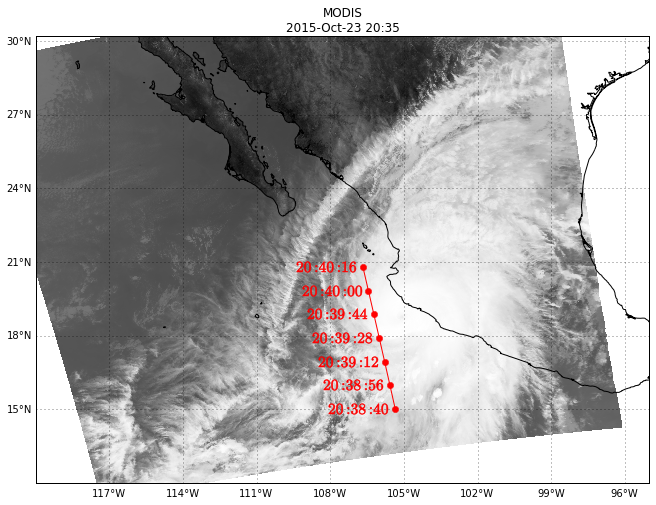

In [71]:
fig, ax = make_map(resolution='10m')
ax.set_extent(mapbox)

im = ax.pcolormesh(mlon[:], mlat[:], ch31_data, cmap=plt.cm.gray_r)
ax.set_title('MODIS\n{}'.format(modis_time.strftime('%Y-%b-%d %H:%M')))

llstep=100
x, y = cldst_lons[i1:i2:llstep], cldst_lats[i1:i2:llstep]
_ = ax.plot(cldst_lons, cldst_lats, color='r', linewidth=0.3)
x_lab, y_lab = cldst_lons[i1:i2:llstep]-1.5, cldst_lats[i1:i2:llstep]
p = ax.plot(x, y, color='r', linestyle='-', marker='o', mec='r', mfc='r', zorder=100)
_ = [ax.plot(i, j, 
             marker=r"${}$".format(it.strftime('%H:%M:%S')),
             mec='r', mfc='r', ms=60, color='r', zorder=100) 
     for (i,j,it) in zip(x_lab,y_lab,cldst_time[i1:i2:llstep])]

In [67]:
cldst_X = np.arange(i1, i2, dtype=np.float32)
cldst_Z = (cldst_height*0.001).astype(np.float32)
cldst_h1 = 0  # km
cldst_h2 = 15  # km
cldst_nz = 500  # Number of pixels in the vertical.
cldst_z = np.linspace(cldst_h1,cldst_h2,cldst_nz)

In [68]:
cldst_radar = ccsat.cloudsat_read_data(cldst_fname)
cldst_radar = cldst_radar[i1:i2,:]
cldst_radar = ccsat.cc_interp2d(cldst_radar.filled(np.nan),
                                cldst_X, cldst_Z,
                                i1, i2, i2-i1, cldst_h2, cldst_h1, cldst_nz)
cldst_radar = cldst_radar.T[::-1,:]

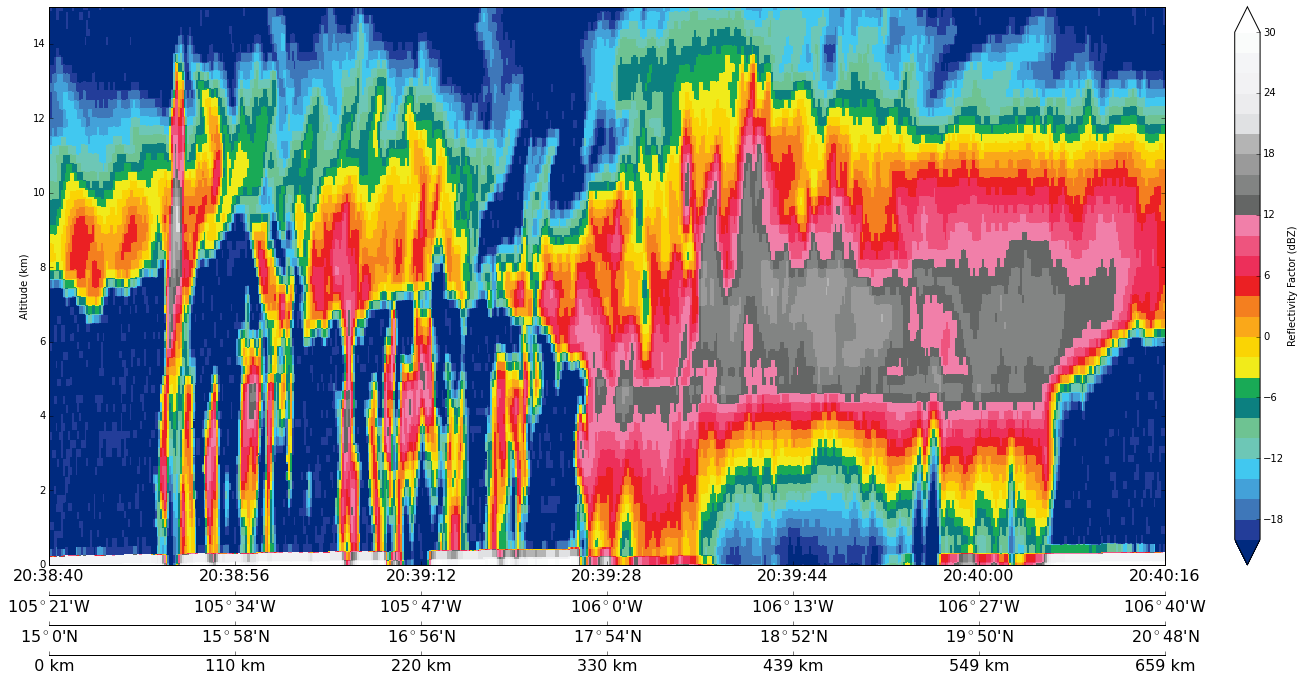

In [69]:
fig, ax = plt.subplots(figsize=(25, 10))
im = ax.pcolormesh(cldst_mdt, cldst_z, cldst_radar, **ccsat.get_cc_cmap('cloudsat'))

ax.set(xlim=[cldst_mdt[0], cldst_mdt[-1]], ylim=[cldst_h1, cldst_h2])

ax.set_ylabel('Altitude (km)')
ax.set_yticklabels(ax.get_yticklabels)

cbar = plt.colorbar(im, ax=ax, extend='both')
cbar.set_label('Reflectivity Factor (dBZ)')

ax.xaxis.set_visible(False)
ax.spines['bottom'].set_color('w')

lon, lat = cldst_lons[i1:i2:llstep], cldst_lats[i1:i2:llstep]

llticks = np.linspace(0,1,len(lon))
xlabels_t = [i.strftime('%H:%M:%S') for i in cldst_time[i1:i2:llstep]]
try:
    import LatLon
    xlabels_lat = [LL.Latitude(i).to_string("d%$^\circ$%m%'%H") for i in lat]
    xlabels_lon = [LL.Longitude(i).to_string("d%$^\circ$%m%'%H") for i in lon]
except ImportError:
    xlabels_lat = ['{}'.format(i) for i in lat]
    xlabels_lon = ['{}'.format(i) for i in lon]

newax_t = add_xaxis_below(ax, llticks, xlabels_t, 0)
newax_lon = add_xaxis_below(ax, llticks, xlabels_lon, 30)
newax_lat = add_xaxis_below(ax, llticks, xlabels_lat, 60)

dist = [0]
for i in xrange(1, len(lon)):
    dist.append(
                r_earth*np.arccos( \
                np.sin(np.radians(lat[i-1]))*np.sin(np.radians(lat[i])) + \
                np.cos(np.radians(lat[i-1])) \
                *np.cos(np.radians(lat[i]))*np.cos(np.radians(lon[i-1]-lon[i]))
                                           )
                )
newax_dist = add_xaxis_below(ax, llticks,['{0:3.0f} km'.format(i) for i in np.cumsum(dist)], 90)

In [ ]:
HTML(html)